<a href="https://colab.research.google.com/github/adamelkholyy/ai-artwork-attention/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Attention in CNNs for Image Classification of AI-Generated and Human-Made Artwork




<strong>Adam El Kholy</strong> \
<strong>University of Bath</strong> \
Last Updated: <strong>30/04/2024</strong>

Free to use under the Apache 2.0 license \
For use in Google Colab using the [AI-Artwork](https://www.kaggle.com/datasets/adamelkholy/human-ai-artwork?rvi=1) dataset available on Kaggle 

The following notebook allows you to train and evaluate a binary classification model using the AI-Artwork dataset as well as providing a basic toolkit for inspecting model attention. A sample of images with which to examine model attention can be downloaded from [GitHub](https://github.com/adamelkholyy/ai-artwork-attention) and the final trained model (a CNN with 6 convolutional and 2 pooling layers, 96% accuracy and a 0.97 F1 score) is available to download [here](https://www.adamelkholy.co.uk/static/model.zip)

The final trained model can also be used online, with image upload functionality, via [adamelkholy.co.uk/artworkai](https://www.adamelkholy.co.uk/artworkai)

In [ ]:
import time
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Table of Contents
1. [Loading Dataset from Kaggle](#Loading-Dataset-from-Kaggle)
2. [Dataset Pre-Processing](#Dataset-Pre-Processing)
3. [Data Augmentation](#Data-Augmentation)
4. [Model Training](#Model-Training)
5. [Loading a Pre-Trained Model](#Loading-a-Pre-Trained-Model)
6. [Plotting Performance Metrics](#Plotting-Performance-Metrics)
7. [Attention Setup and Image Filtering](#Attention-Setup-and-Image-Filtering)
8. [Examining Model Attention](#Examining-Model-Attention)
9. [Appendix A: Loading the AI-ArtBench Dataset](#Appendix-A:-Loading-the-AI-ArtBench-Dataset)
10. [Appendix B: Model Definitions](#appendix-b-model-definitions)

# Loading Dataset from Kaggle



In order to download the dataset from Kaggle a free API key is necessary. [The following tutorial explains how to acquire said key](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/). Once acquired, uploading the key via the kaggle.json file will allow for the downloading of Kaggle datasets

In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"john_appleseed","key":"API_key"}'}

We now install the Kaggle library on Colab

In [ ]:
! pip install -q kaggle

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

For this notebook we will using the [AI-Artwork](https://www.kaggle.com/datasets/adamelkholy/human-ai-artwork) dataset. Alternatively if you would like to run the experiments in this notebook using the [AI-ArtBench](https://www.kaggle.com/datasets/ravidussilva/real-ai-art) dataset by Ravidu Silva please see [Appendix A](#appendix-a). We first download and unzip the Combined Dataset

In [ ]:
!kaggle datasets download -d adamelkholy/human-ai-artwork/

100% 62.4G/62.4G [49:31<00:00, 29.6MB/s]
100% 62.4G/62.4G [49:31<00:00, 22.6MB/s]


In [2]:
! mkdir data
! unzip human-ai-artwork.zip -d data;

Streaming output truncated to the last 10 lines.
  inflating: data/data/Human_Ukiyo_e/utagawa-toyokuni_nakamura-nosio-the-second-performs-the-dance-dodzedzi-1796.jpg  
  inflating: data/data/Human_Ukiyo_e/utagawa-toyokuni_nakamura-utaemon-1.jpg  
  inflating: data/data/Human_Ukiyo_e/utagawa-toyokuni_nakamura-utaemon.jpg  
  inflating: data/data/Human_Ukiyo_e/utagawa-toyokuni_segawa-kikunojo-iii-and-bando-mitsugoro-ii-1798.jpg  
  inflating: data/data/Human_Ukiyo_e/utagawa-toyokuni_seki-sanjuro.jpg  
  inflating: data/data/Human_Ukiyo_e/utagawa-toyokuni_the-actor-otani-monzo-in-the-role-of-igarashi-tenzen.jpg  
  inflating: data/data/Human_Ukiyo_e/utagawa-toyokuni_the-heian-courtier.jpg  
  inflating: data/data/Human_Ukiyo_e/utagawa-toyokuni_the-promenade.jpg  
  inflating: data/data/Human_Ukiyo_e/utagawa-toyokuni_three-beauties-playing-battledore-and-shuttlecock.jpg  
  inflating: data/data/Human_Ukiyo_e/utagawa-toyokuni_three-beauties-snow.jpg  


In [ ]:
! rm /content/human-ai-artwork.zip

The dataset is now fully downloaded and unpacked in the data/ directory

# Dataset Pre-Processing

In order to train our model we must load the data from its directory into a dataset object using ```tf.keras.utils.image_dataset_from_directory```. We then use a stratified shuffled split of 60% training, 20% validation and 20% test data along with a batch size of 32 across 3 epochs

In [ ]:
class_weights = {0: 1.0, 1: 1.0}
num_classes = 1
batch_size = 32
img_height = 256
img_width = 256
data_dir = "/content/data/data/"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 271993 files belonging to 52 classes.
Using 163196 files for training.


In [ ]:
val_test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 271993 files belonging to 52 classes.
Using 108797 files for validation.


We split the original validation set in half in order to generate our test set

In [ ]:
val_batches = int(0.5 * len(val_test_ds))
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

We initialise the model's bias in order to adjust for the class imbalance

In [ ]:
pos = 190549   # number of AI-Generated artworks 
neg = 81457    # number of Human-Made artworks
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

The original Combined Dataset is organised into 52 classes. As such we must map the images to binary labels (1 for AI-generated artworks and 0 for human-made). The first 25 original classes are AI-generated

In [ ]:
""" maps images to binary classes """
def classes_to_binary(image, label):
  # in the Combined Dataset our first 25 images are AI
  new_label = tf.where(label < 25, 1, 0)
  return image, new_label

train_ds = train_ds.map(classes_to_binary)
val_ds   = val_ds.map(classes_to_binary)
test_ds  = test_ds.map(classes_to_binary)

In [ ]:
# sanity check
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
print(labels_batch)

(32, 256, 256, 3)
(32,)
tf.Tensor([1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0], shape=(32,), dtype=int32)


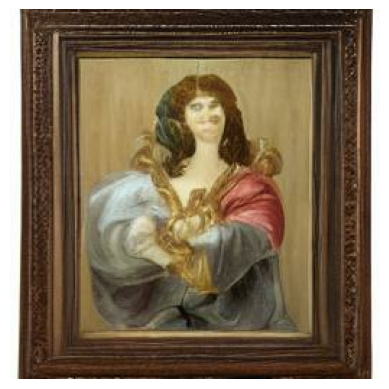

In [ ]:
plt.imshow(tf.cast(image_batch[0], tf.int32))
plt.axis("off")
plt.show()

The first image in our batch is clearly AI-Generated, with the label 1 indicating our binary mapping was succesful

# Data Augmentation

In order to control for image size during model inference we augment our dataset. We randomly resize every image in order to introduce a level of visual noise across all samples, such that the model does not overfit so as to erroneously classify images based on size

In [ ]:
""" augments the given image by randomly resizing the image and then rescaling it back down to its original size (256x256)"""
def augment(image, label):
    # generate a random rescale factor
    min_scale = 0.5
    max_scale = 2.0
    scale_factor = tf.random.uniform(shape=[], minval=min_scale, maxval=max_scale)

    # resize the image using bilinear interpolation then rescale back to original size
    resized_image = tf.image.resize(image, tf.cast(tf.cast(tf.shape(image)[1:3], tf.float32) * scale_factor, tf.int32))
    rescaled_image = tf.image.resize(resized_image, tf.shape(image)[1:3])

    return rescaled_image, label

(**Optional**) The cell below applies the augmentation operation to our dataset

In [ ]:
train_ds = train_ds.map(augment)
val_ds   = val_ds.map(augment)
test_ds  = test_ds.map(augment)

In [ ]:
# sanity check
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


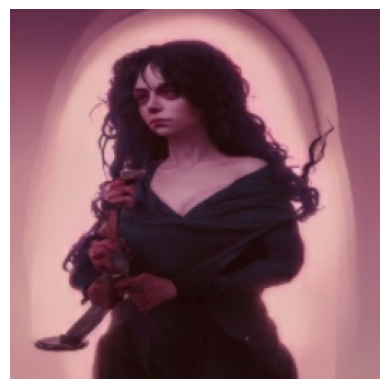

In [ ]:
plt.imshow(tf.cast(image_batch[0], tf.int32))
plt.axis("off")
plt.show()

We can clearly see evidence of compression in the image from the noise surrounding the figure, indicating our augmentation was successful

# Model Training


Having preprocessed our data we now set about training our model. Below we have defined a suitable model (a 6 convolutional with 2 pooling layer CNN) for the task

In [ ]:
example_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, bias_initializer=output_bias, activation="sigmoid")
])
example_model._name = "example_model"

We now define helper functions for model training in order to setup our model pipeline. We use ADAM optimisation and a cross-entropy loss function

In [ ]:
# specify path to save the model and its evaluation
path = "/content/"

In [ ]:
# we define the performance metrics we want to track for our model
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'), # equiv. to model's loss
      tf.keras.metrics.MeanSquaredError(name='MSE'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='roc', curve='ROC'),             # receiver operating characteristic curve
      tf.keras.metrics.AUC(name='prc', curve='PR'),              # precision-recall curve
]

We setup our own custom tensorflow callback in order to track our performance metrics across batches during training and testing

In [ ]:
""" custom tensorflow history object used to record performance metrics during training
    and plot rolling average graphs """
class CustomHistory(tf.keras.callbacks.Callback):
    def __init__(self):
      super(CustomHistory, self).__init__()
      self.losses = []
      self.prcs = []
      self.recalls = []
      self.precisions = []
      self.accuracies = []
      self.mses = []

    """ called upon completion of each batch during training, records all performance metrics """
    def on_train_batch_end(self, batch, logs=None):
      self.losses.append(logs['loss'])
      self.mses.append(logs['MSE'])
      self.accuracies.append(logs['accuracy'])
      self.prcs.append(logs['prc'])
      self.recalls.append(logs['recall'])
      self.precisions.append(logs['precision'])

    """ called upon completion of each batch during testing, records all performance metrics """
    def on_test_batch_end(self, batch, logs=None):
      self.losses.append(logs['loss'])
      self.mses.append(logs['MSE'])
      self.accuracies.append(logs['accuracy'])
      self.prcs.append(logs['prc'])
      self.recalls.append(logs['recall'])
      self.precisions.append(logs['precision'])

    """ return all performance metrics """
    def get_metrics(self):
      return self.losses, self.mses, self.accuracies, self.prcs, self.recalls, self.precisions


In [ ]:
""" compile the model with ADAM optimisation and cross-entropy loss """
def compile_model(model):
  model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=METRICS
  )
  return model

In [ ]:
"""
    fits the model to training data.
    returns: the model and our custom history callback object
"""
def fit_model(model):
  history_callback = CustomHistory()
  model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    class_weight=class_weights,
    callbacks=[history_callback]
  )
  return model, history_callback

In [ ]:
""" evaluate model on test set and return performance metrics """
def evaluate_model_on_test(model):
  eval_metrics = model.evaluate(test_ds)
  return eval_metrics

In [ ]:
""" save model to path in the .keras format """
def save_model(model):
  model_name = model._name
  print("\nSaving " + model_name + ".keras")
  try:
    model.save(path + model_name + ".keras")
  except:
    print("Error saving " + model_name + ".keras...")
    return
  print(model_name + ".keras saved successfully.\n")

In [ ]:
""" save data (evaluation metrics or performance history) to .txt file """
def save_data(data, filename):
  print("Saving data for " + filename)
  try:
    with open(path + filename+".txt", 'w') as writefile:
      writefile.write(str(data))
  except:
    print("Error saving data for " + filename)
    return
  print("Data saved.\n")

We implement a function to execute the entire training and evaluation pipeline for a given model as follows

In [ ]:
"""
    execute full training and evaluation pipeline, returning model, evaluation on test set
    and performance metrics during training (history)
    takes ADAM learning rate (lr) as an optional argument (default 0.001)
    returns model.keras, performance metrics evaluation on test set and model history (CustomHistory object)
"""
def train_model_pipeline(model, lr=0.001):
  start = time.time()
  model_name = model._name
  print("Now training " + model_name)

  # compile model and fit to training data
  compiled_model = compile_model(model)
  compiled_model.optimizer.learning_rate = lr
  trained_model, history = fit_model(compiled_model)

  # save model.keras and history data
  save_data(history.get_metrics(), model_name+"_history")
  save_model(trained_model)

  # evaluate on test set and save evaluation
  evals = evaluate_model_on_test(trained_model)
  save_data(evals, model_name + "_evals")

  time_taken = time.time() - start
  print("Training complete in", round((time_taken)/60, 2), "minutes")
  return trained_model, evals, history


Using Google Colab's T4 GPU the example model should take approximately 2 hours to train (alternatively see the next section to download the pre-trained model)

In [ ]:
model, evals, history = train_model_pipeline(example_model)

Now training example_model
Epoch 1/3
   6/5100 [..............................] - ETA: 12:56 - loss: 1.3182 - accuracy: 0.6510 - cross entropy: 1.3182 - MSE: 0.2978 - tp: 116.0000 - fp: 44.0000 - tn: 9.0000 - fn: 23.0000 - precision: 0.7250 - recall: 0.8345 - roc: 0.5223 - prc: 0.7229

5100/5100 [==============================] - 2041s 397ms/step - loss: 0.4293 - accuracy: 0.8015 - cross entropy: 0.4293 - MSE: 0.1383 - tp: 102780.0000 - fp: 20651.0000 - tn: 28014.0000 - fn: 11751.0000 - precision: 0.8327 - recall: 0.8974 - roc: 0.8561 - prc: 0.9319 - val_loss: 0.3469 - val_accuracy: 0.8475 - val_cross entropy: 0.3469 - val_MSE: 0.1087 - val_tp: 34149.0000 - val_fp: 4367.0000 - val_tn: 11954.0000 - val_fn: 3930.0000 - val_precision: 0.8866 - val_recall: 0.8968 - val_roc: 0.9125 - val_prc: 0.9597
Epoch 2/3
5100/5100 [==============================] - 1993s 391ms/step - loss: 0.2729 - accuracy: 0.8864 - cross entropy: 0.2729 - MSE: 0.0825 - tp: 107605.0000 - fp: 11613.0000 - tn: 37052.0000 - fn: 6926.0000 - precision: 0.9026 - recall: 0.9395 - roc: 0.9447 - prc: 0.9739 - val_loss: 0.2132 - val_accuracy: 0.9190 - val_cross entropy: 0.2132 - val_MSE: 0.0613 - val_tp: 36259.0000 - val_fp: 2592.0000 - val_tn: 13736.0000 - val_fn: 1813.0000 - val_precision: 0.9333 - val_reca

# Loading a Pre-Trained Model

Alternatively you can load a pre-trained model (in the .h5 file format). We provide access to our final trained model (a CNN with 6 convolutional and 2 pooling layers, trained on the Augmented dataset) available to download [here](https://www.adamelkholy.co.uk/static/model.zip)

In [ ]:
# specify path to model
model_path = "/content/example_model.h5"
model = tf.keras.models.load_model(model_path)

# Plotting Performance Metrics


If you are loading a previously saved history callback from a txt file (such as the example_history.txt available on [GitHub](https://github.com/adamelkholyy/ai-artwork-attention/blob/main/example_history.txt)) the following cell will read the history data. If you trained the model within this notebook then this step is unnecessary as the history callback is already loaded in the ```history``` variable

In [ ]:
""" loads the history data at the specified path and returns an array of metric histories
    returns arr: a 2D array containing: [[losses], [mses], [accuracies], [prcs], [recalls], [precisions]]
    where [metric] is a 1D array of metric values recorded at the end of each batch during training and testing
"""
def get_history(path):
  file = open(path, "r")
  for line in file:
    arr = eval(line)
  file.close()
  return arr

In [ ]:
# specify path from which to load custom history data
history_path = "/content/example_history.txt"
history = get_history(history_path)

In [ ]:
# unpack performance metrics
losses, mses, accuracies, prcs, recalls, precisions = history

We now plot the rolling average graphs of loss, accuracy, recall and precision across batches during training and testing. We take the rolling average in order to avoid the skewing affects of anomalous data on our visualisation

In [ ]:
""" plot the rolling average graph for the given metric during training and testing for the given metric data"""
def plot_metric_rolling_average_graph(x, y, title, xlabel, ylabel, cutoff=0):
  plt.plot(x[cutoff:], (np.cumsum(y) / x)[cutoff:])
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.ylim(0,1)
  plt.show()

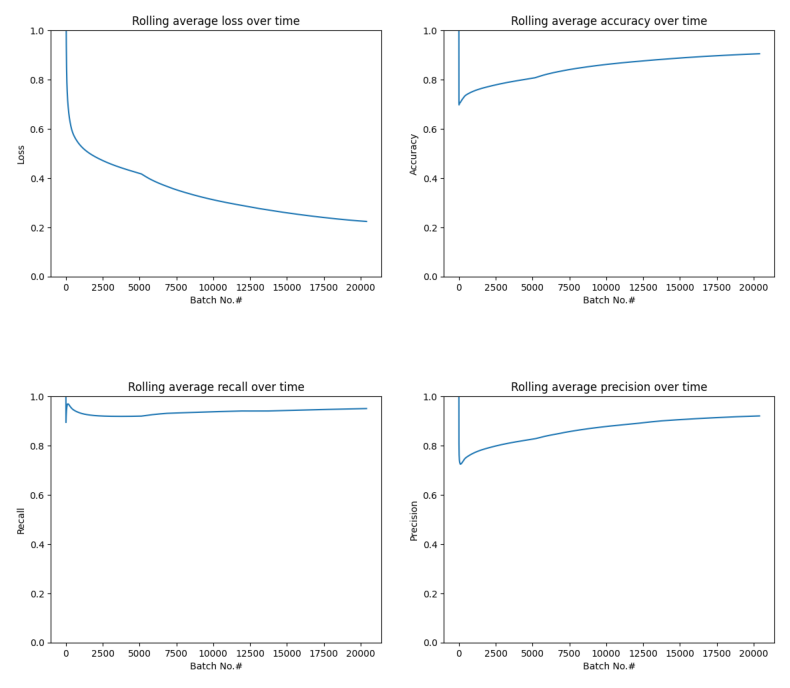

In [8]:
x = [x for x in range(len(losses))]
plot_metric_rolling_average_graph(x, losses, "Rolling average loss over time", "Batch No.#", "Loss")
plot_metric_rolling_average_graph(x, accuracies, "Rolling average accuracy over time", "Batch No.#", "Accuracy")
plot_metric_rolling_average_graph(x, recalls, "Rolling average recall over time", "Batch No.#", "Recall")
plot_metric_rolling_average_graph(x, precisions, "Rolling average precision over time", "Batch No.#", "Precision")

# Attention Setup and Image Filtering

We now provide a simple toolkit for model attention analysis. Example attention images can be found in the attention_dataset folder on [Github](https://github.com/adamelkholyy/ai-artwork-attention/tree/main/attention_dataset/0)

In [ ]:
# specify path for loading the attention dataset
path = "/content/attention_dataset"

We create a new model to simply extract the activation maps of the model which for which we would like to inspect attention. Credit: [Rodrigo Silva 2023](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a)

In [ ]:
# https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# get model layers and inputs
benchmark_layers = model.layers
benchmark_input = model.input

# create a new model to output the feature maps of the original model
layer_outputs_benchmark = [layer.output for layer in benchmark_layers]
features_benchmark = Model(inputs=benchmark_input, outputs=layer_outputs_benchmark)

We now create our attention dataset object

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

attention_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4 files belonging to 1 classes.


In [ ]:
# sanity check
for image_batch, labels_batch in attention_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch[0])
  break

(4, 256, 256, 3)
(4,)
tf.Tensor(0, shape=(), dtype=int32)


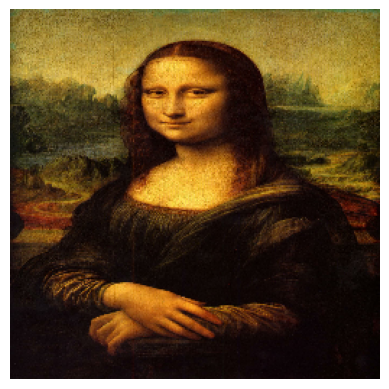

In [ ]:
input_image_batch = np.expand_dims(image_batch[0], axis=0)
plt.axis("off")
plt.imshow(tf.cast(image_batch[0], tf.int32))

In our analysis we found our model to be replicating the existing Sobel filtering image preprocessing operations. We now inspect the vertical and horizontal gradient Sobel filters applied to our image as well as the Laplacian filter operation

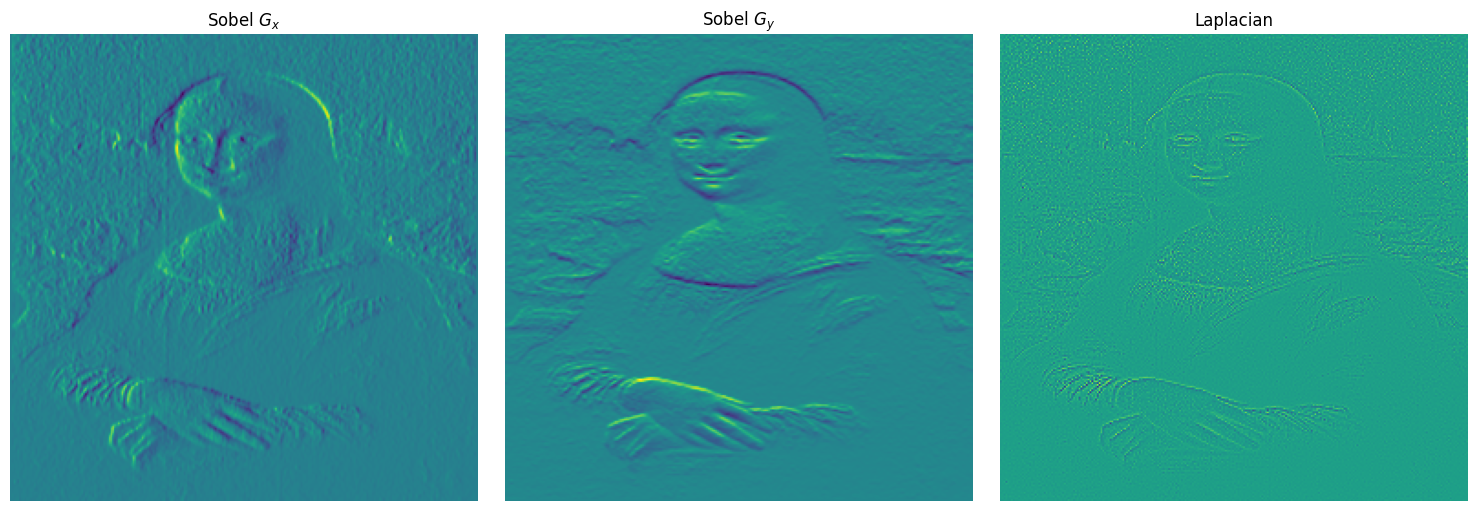

In [ ]:
from google.colab.patches import cv2_imshow

image = image_batch[0].numpy()
grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# apply filters: Sobel x, y and Laplacian
gX = cv2.Sobel(grey, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3) #x gradient Sobel filter with 3x3 kernel
gY = cv2.Sobel(grey, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3) #y gradient Sobel filter with 3x3 kernel
laplacian = cv2.Laplacian(grey,cv2.CV_32F)

# resize image for display purposes
resize_img = lambda x: cv2.resize(x, (256, 256))
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(resize_img(gX), cmap='viridis')
ax[0].set_title("Sobel $G_{x}$")
ax[0].axis('off')

ax[1].imshow(resize_img(gY), cmap='viridis')
ax[1].set_title("Sobel $G_{y}$")
ax[1].axis('off')

ax[2].imshow(laplacian, cmap='viridis')
ax[2].set_title('Laplacian')
ax[2].axis('off')

plt.tight_layout()
plt.show()

# Examining Model Attention

We now provide out simple toolkit for inspecting model attention, featuring numerous functions to filter the model's activation maps for the given image

Across all of our attention inspection functions the following two parameters are frequently referenced
```
activations: an array of all the activation maps within the model across all channels and layers
layer_names: an array containing the name of each layer in the model
```
To begin we show the activation maps across all 32 channels in the first layer

In [ ]:
"""
    displays all 32 activation maps across all layers
"""
def show_all_channels(activations):
  for i, activation in enumerate(activations):

      # skip the rescaling layer
      if i==0:
        continue

      # we cannot visualise the final dense layers
      if len(activation.shape) <= 2:
        print(activation)
        continue

      num_channels = activation.shape[-1]
      num_cols = 5
      num_rows = 7
      plt.figure(figsize=(25, 25))

      for j in range(num_channels):
          plt.subplot(num_rows, num_cols, j + 1)
          plt.imshow(activation[0, :, :, j], cmap='viridis')
          plt.axis('off')

      plt.subplots_adjust(wspace=-0.67, hspace=0.01)
      plt.show()

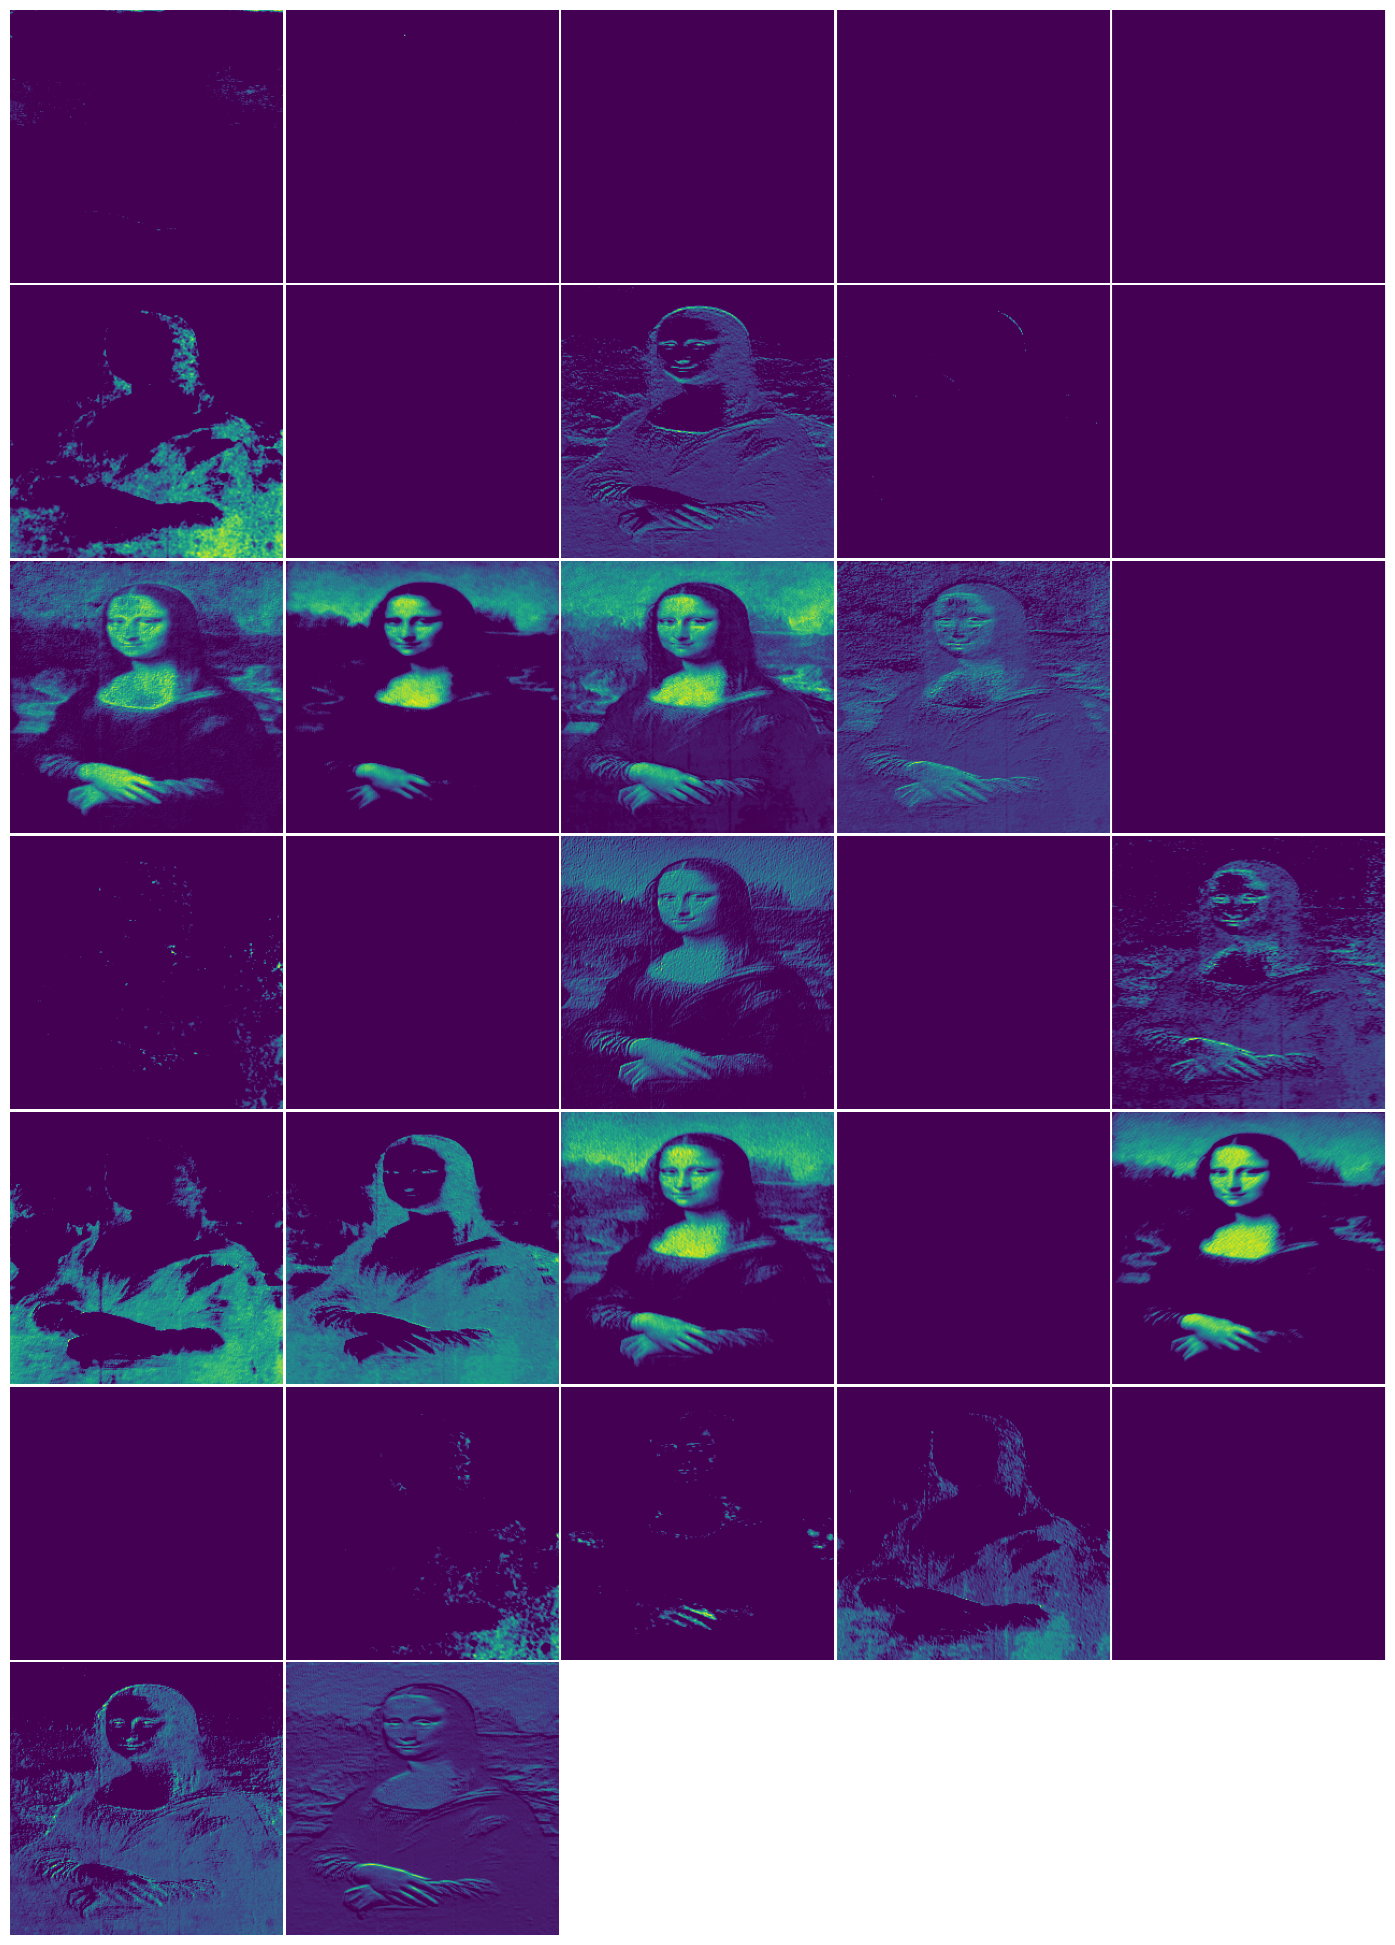

In [6]:
# get the activations of all layers for the input image
activations = features_benchmark.predict(input_image_batch)
layer_names = [layer._name for layer in model.layers]

show_all_channels(activations[:2])

We now display the highest overall magnitude activation map in each layer

In [ ]:
"""
    returns the highest activation map and its index for the given array of activations
"""
def get_highest_magnitude_map(activation):
    channel_sums = np.sum(activation, axis=(0, 1, 2))
    highest_index = np.argmax(channel_sums)
    highest_activation = activation[0, :, :, highest_index]
    return highest_activation, highest_index

In [ ]:
"""
    displays the highest overall magnitude activation map and its channel for each layer of the model
"""
def show_highest_weighted_maps(activations, layer_names):
  plt.figure(figsize=(20, 20))
  num_cols =3
  num_rows = 4

  for i, activation in enumerate(activations):
      # skip the rescaling layer
      if i==0:
        continue

      # we cannot visualise the final dense layers
      if len(activation.shape) <= 2:
        break

      highest_activation, highest_index = get_highest_magnitude_map(32, activation)
      plt.subplot(num_rows, num_cols, i)

      # assuming the activation has shape (1, height, width, channels)
      plt.imshow(highest_activation, cmap='viridis')
      plt.title(f'{layer_names[i].capitalize()} (layer {i}): channel {highest_index}')
      plt.axis('off')

  plt.suptitle(f"Highest weighted activation map for each layer", fontsize=16, y=0.91)
  plt.subplots_adjust(wspace=-0.5, hspace= 0.10)
  plt.show()

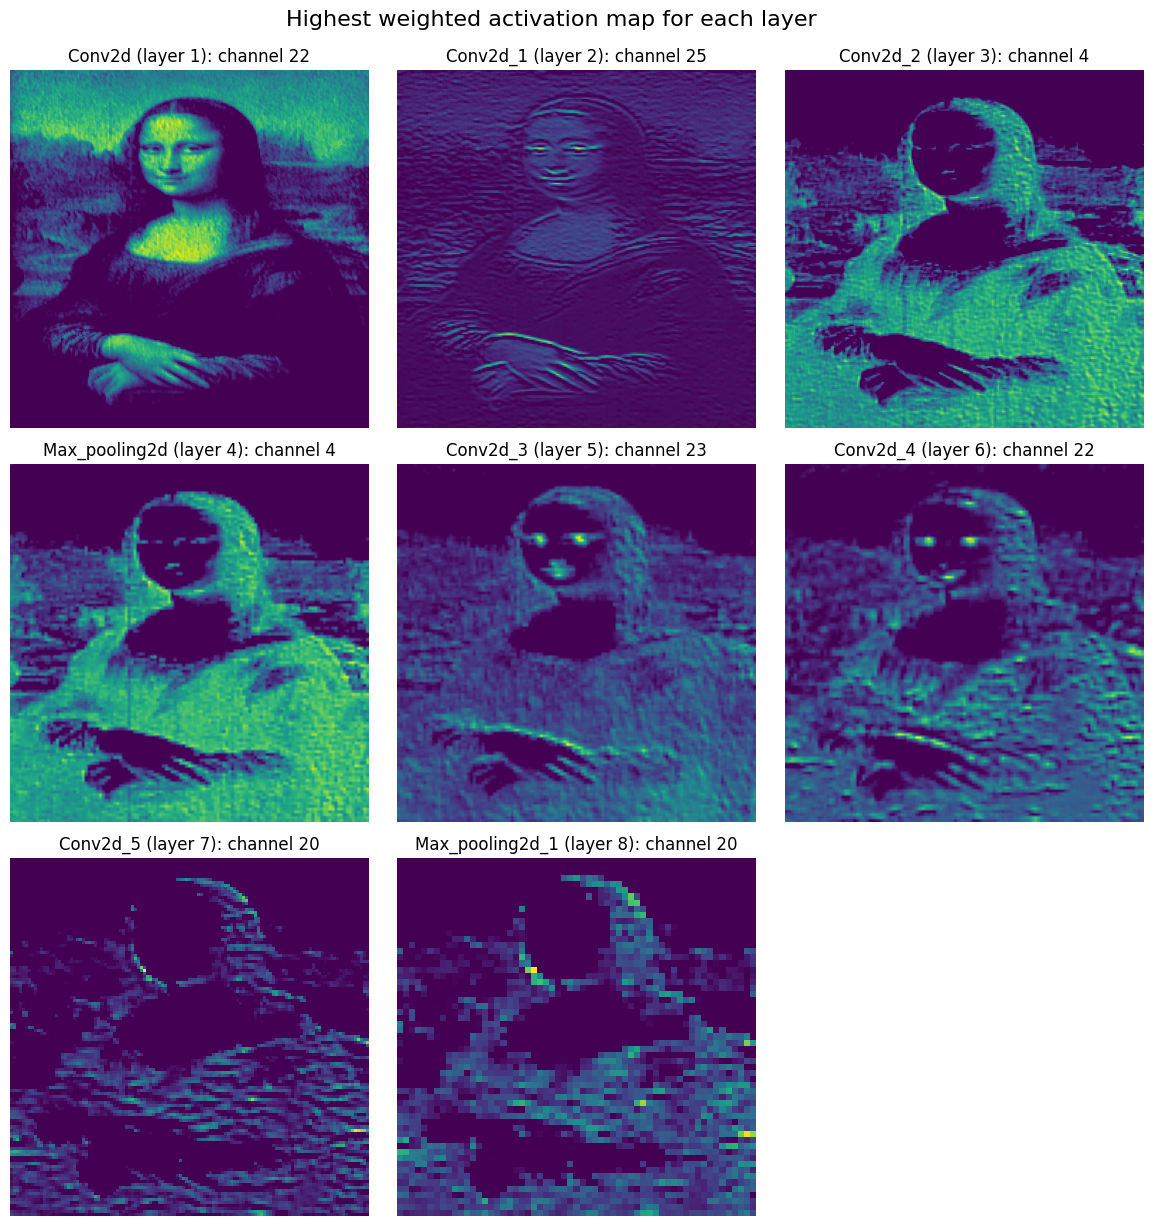

In [ ]:
show_highest_weighted_maps(activations, layer_names)

We now visualise the maps of a single channel across all layers of the model

In [ ]:
"""
    displays the maps from a single specified channel across all layers of the model
"""
def visualise_single_channel(channel, activations, layer_names):

  plt.figure(figsize=(20, 20))
  num_cols = 3
  num_rows = 4

  for i, activation in enumerate(activations):

      # skip the rescaling layer
      if i==0:
        continue

      # we cannot visualise the final dense layers
      if len(activation.shape) <= 2:
        break

      plt.subplot(num_rows, num_cols, i)
      plt.imshow(activation[0, :, :, channel], cmap='viridis')
      plt.title(f'Layer {i}: {layer_names[i].capitalize()}')
      plt.axis('off')

  plt.suptitle(f"Channel {channel} across all layers", fontsize=16, y=0.91)
  plt.subplots_adjust(wspace=-0.5, hspace= 0.10)
  plt.show()

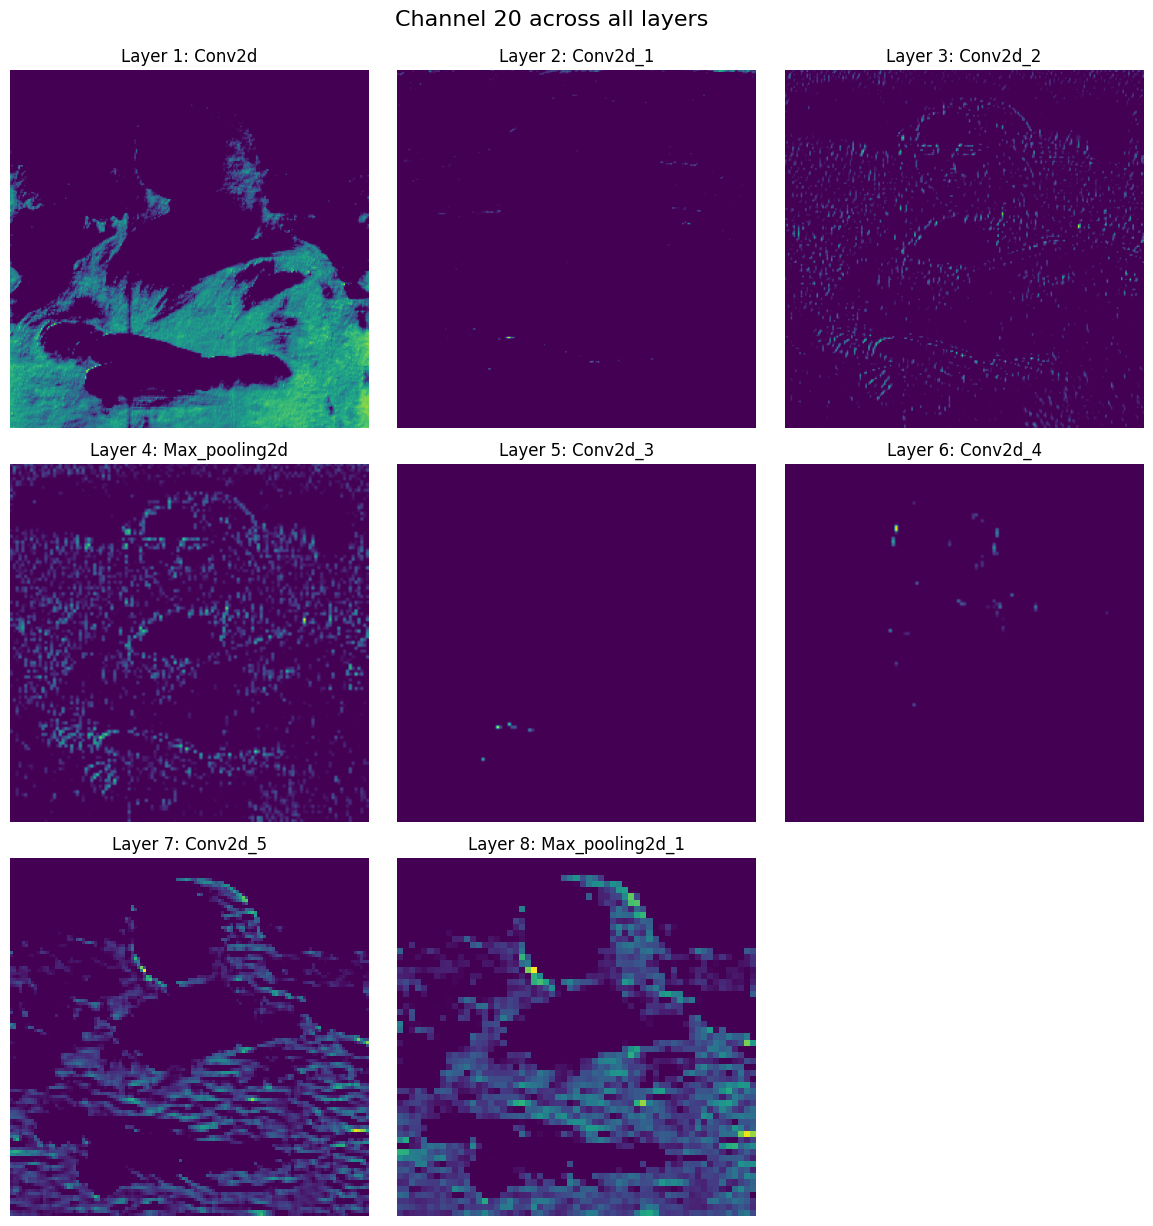

In [ ]:
visualise_single_channel(20, activations, layer_names)

Finally we visualise a single activation map for the specified layer and channel

In [ ]:
def visualise_single_map(layer_num, channel, activations, layer_names):
  activation = activations[layer_num]
  plt.imshow(activation[0, :, :, channel], cmap='viridis')
  plt.title(f'{layer_names[layer_num].capitalize()} (layer {layer_num}): channel {channel}')
  plt.axis('off')
  plt.subplots_adjust(wspace=-0.5, hspace= 0.10)
  plt.show()

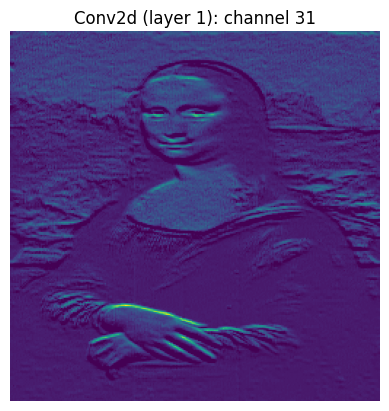

In [ ]:
visualise_single_map(1, 31, activations, layer_names)

<a name="appendix-a"></a>
# Appendix A: Loading the AI-ArtBench Dataset

All code in this notebook can be run using data from the AI-ArtBench dataset, with a couple of minor adjustments necessary due to the difference in structure between [AI-ArtBench Dataset](https://www.kaggle.com/datasets/ravidussilva/real-ai-art) and the Combined Dataset. First we simply download the dataset as before

In [ ]:
!kaggle datasets download -d ravidussilva/real-ai-art

In [ ]:
! mkdir data
! unzip real-ai-art.zip -d data;

Next the tensorflow dataset objects for AI-ArtBench must be loaded using seperate train and test directories as follows

In [ ]:
class_weights = {0: 1.0, 1: 1.0}
num_classes = 1
batch_size = 32
img_height = 256
img_width = 256
train_dir = "/content/data/Real_AI_SD_LD_Dataset/train/"
test_dir = "/content/data/Real_AI_SD_LD_Dataset/test/"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

The different datasets have different class imbalances respectively so we adjust accordingly

In [ ]:
pos = 125015
neg = 60000
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

Finally since there are a lower number of original classes in the AI-ArtBench dataset we must adjust our mapping of the classes to binary labels

In [ ]:
def classes_to_binary(image, label):
  new_label = tf.where(label < 20, 1, 0)  # first 20 classes are AI images
  return image, new_label                 # we assign AI images the label 1

train_ds = train_ds.map(classes_to_binary)
val_ds   = val_ds.map(classes_to_binary)
test_ds  = test_ds.map(classes_to_binary)

Following these minor adjustments all the code in the notebook should run as normal using the AI-ArtBench dataset as opposed to the default Combined Dataset

In [7]:
# sanity check
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
print(labels_batch)

(32, 256, 256, 3)
(32,)
tf.Tensor([1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0], shape=(32,), dtype=int32)


# Appendix B: Model Definitions

We tested a number of different CNN architectures with a varied number of convolutional, dropout and pooling layers. Below we show a subsample of different architectures tested

In [ ]:
arch_4_conv_2_pooling_combined = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, bias_initializer=output_bias, activation="sigmoid")
])
arch_4_conv_2_pooling_combined._name = "arch_4_conv_2_pooling_combined"

In [ ]:
pool_6_conv_6_pooling_combined = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, bias_initializer=output_bias, activation="sigmoid")
])
pool_6_conv_6_pooling_combined._name = "pool_6_conv_6_pooling_combined"

In [ ]:
aug_dropout_50_6_conv_2_pooling_combined = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(.5),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(.5),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, bias_initializer=output_bias, activation="sigmoid")
])
aug_dropout_50_6_conv_2_pooling_combined._name = "aug_dropout_50_6_conv_2_pooling_combined"